In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.graph.create_osmnx_graph import OSMnxGraph
from src.graph_layering.graph_layer_creator import GraphLayerController, SourceType
from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from sklearn.manifold import TSNE

import folium

from src.graph_layering.hetero_data import create_hetero_data
import numpy as np

import torch.nn as nn
import torch_geometric.nn as gnn
import torch_geometric.data as hd
from torch_geometric.loader import DataLoader
import torch
import torch.optim as optim
import torch.nn.functional as F

In [3]:
GRAPH_LOCATION = "/home/staszek/mgr/gradient/gradient/data/wro/wro-map.osm"
ACCIDENTS_LOCATION = "/home/staszek/mgr/gradient/gradient/data/wypadki-pl/accidents.csv"
ORGANIZED_DATASETS_LOCATION = (
    "/home/staszek/mgr/gradient/gradient/data/organized-datasets"
)

# 1. Utworzenie geodataframes dla OSMNX nodes, edges oraz hexes

Atrybuty:

OSMNX nodes i edges mają te atrybuty, które są obecne w OSMNX. Hexes mają atrybuty z CountEmbeddera.


In [4]:
df_accidents = pd.read_csv(ACCIDENTS_LOCATION)
df_accidents.drop(
    df_accidents[(df_accidents["mie_nazwa"] != "Wrocław")].index, inplace=True
)
df_accidents.drop(columns="uczestnicy", inplace=True)

In [5]:
geometry = [
    Point(xy) for xy in zip(df_accidents["wsp_gps_x"], df_accidents["wsp_gps_y"])
]
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry=geometry)
gdf_accidents.drop(columns=["wsp_gps_x", "wsp_gps_y"], inplace=True)
G = ox.graph.graph_from_place("Wrocław, Poland", network_type="drive")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
assert gdf_edges.crs == gdf_nodes.crs
osmnx_crs = gdf_edges.crs

In [7]:
gdf_nodes_geometry_xy = gdf_nodes[["geometry", "x", "y"]]
gdf_edges_geometry = gdf_edges["geometry"]

In [8]:
osmnx_graph = OSMnxGraph(gdf_accidents, gdf_nodes, gdf_edges)
osmnx_graph._aggregate_accidents(aggregation_type="node")
accidents_binary_y = (osmnx_graph.gdf_nodes["accidents_count"] > 0).astype(int)
osmnx_graph.create_graph(aggregation_type="node", normalize_y=True)

/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Data(x=[7222, 7], edge_index=[2, 17002], y=[7222], street_count=[7222], highway=[7222], ref=[7222], accidents_count=[7222], osmid=[17002], oneway=[17002], lanes=[17002], name=[17002], edge_highway=[17002], maxspeed=[17002], reversed=[17002], length=[17002], geometry=[17002], edge_ref=[17002], access=[17002], bridge=[17002], junction=[17002], width=[17002], tunnel=[17002], crs=epsg:4326)

In [9]:
osmnx_nodes = osmnx_graph.get_node_attrs()
osmnx_nodes = osmnx_nodes.merge(
    left_index=True, right_index=True, right=accidents_binary_y
).merge(left_index=True, right_index=True, right=gdf_nodes_geometry_xy)
osmnx_nodes = osmnx_nodes.reset_index(names="osmid").rename_axis("node_id", axis=0)
osmnx_nodes = gpd.GeoDataFrame(osmnx_nodes, geometry="geometry", crs=osmnx_crs)

In [10]:
osmnx_edges = osmnx_graph.get_edge_attrs()
osmnx_edges = osmnx_edges.merge(
    left_index=True, right_index=True, right=gdf_edges_geometry
)
osmnx_edges = osmnx_edges.reset_index().rename_axis("edge_id", axis=0)
osmnx_edges = gpd.GeoDataFrame(osmnx_edges, geometry="geometry", crs=osmnx_crs)

/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/staszek/mgr/gradient/gradient/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter '

In [11]:
hexes: gpd.GeoDataFrame = gpd.read_file(
    os.path.join(
        ORGANIZED_DATASETS_LOCATION, "wroclaw/2017/h9/count-embedder/dataset.gpkg"
    )
)

**_Uwaga_**: Domyślnie w hexach zescrapowanych jest liczba wypadków w ramach hexa (policzona count embedderem). W tym eksperymencie jednak korzystamy z przynależności wypadków do OSMNX nodes, dlatego proponowaną liczbę wypadków usuwamy.


In [12]:
hexes = (
    hexes.rename(columns={"region_id": "h3_id"})
    .rename_axis("region_id", axis=0)
    .drop(columns="accidents_count")
)  # we will be using different aggregation type than the one in the dataset

## Przedstawienie wynikowych dataframes


In [13]:
display(osmnx_nodes)
display(osmnx_edges)
display(hexes)

,osmid,street_count,crossing,give_way,mini_roundabout,motorway_junction,traffic_signals,turning_circle,accidents_count,geometry,x,y
node_id,,,,,,,,,,,,
0,95584835,4,0,0,0,0,0,0,1,POINT (17.04951 51.08311),17.049513,51.083111
1,95584841,3,0,0,0,0,0,0,0,POINT (17.06437 51.08470),17.064367,51.084699
2,95584850,4,0,0,0,0,0,0,1,POINT (17.03506 51.08333),17.035057,51.083328
3,95584852,4,0,0,0,0,0,0,1,POINT (17.05357 51.08301),17.053573,51.083009
4,95584855,4,0,0,0,0,0,0,1,POINT (17.03468 51.08333),17.034685,51.083333
...,...,...,...,...,...,...,...,...,...,...,...,...
7217,11739687387,1,0,0,0,0,0,0,0,POINT (17.10860 51.14470),17.108603,51.144699
7218,11756705589,1,0,0,0,0,0,0,0,POINT (17.03151 51.10562),17.031511,51.105617
7219,11775998357,3,0,0,0,0,0,0,0,POINT (17.08684 51.07214),17.086838,51.072136


,u,v,key,oneway,lanes,maxspeed,reversed,length,width,highway_living_street,...,junction_0,junction_circular,junction_roundabout,bridge_0,bridge_viaduct,bridge_yes,tunnel_0,tunnel_building_passage,tunnel_yes,geometry
edge_id,,,,,,,,,,,,,,,,,,,,,
0,95584835,297779709,0,1,2,50,0,178.450,0.0,0,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,95584835,241778108,0,1,2,50,0,30.730,0.0,0,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,95584841,164895026,0,0,0,0,0,14.714,0.0,0,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.06437 51.08470, 17.06450 51.08460)"
3,95584841,268480775,0,1,2,50,0,125.913,0.0,0,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.06437 51.08470, 17.06412 51.084..."
4,95584850,95584855,0,1,3,50,0,25.991,0.0,0,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.03506 51.08333, 17.03468 51.08333)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16997,11775998357,370441849,0,0,0,0,0,160.277,0.0,1,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.08684 51.07214, 17.08688 51.072..."
16998,11775998357,370441795,0,0,0,0,1,158.561,0.0,1,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.08684 51.07214, 17.08679 51.072..."
16999,11775998357,11775998362,0,0,0,0,0,120.519,0.0,1,...,1,0,0,1,0,0,1,0,0,"LINESTRING (17.08684 51.07214, 17.08672 51.072..."


,h3_id,aeroway_aerodrome,aeroway_apron,aeroway_gate,aeroway_hangar,aeroway_helipad,aeroway_holding_position,aeroway_parking_position,aeroway_runway,aeroway_taxiway,...,waterway_dam,waterway_ditch,waterway_drain,waterway_fish_pass,waterway_lock_gate,waterway_river,waterway_stream,waterway_waterfall,waterway_weir,geometry
region_id,,,,,,,,,,,,,,,,,,,,,
0,891e204e4a7ffff,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,"POLYGON ((17.04297 51.07181, 17.04301 51.07013..."
1,891e204239bffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((16.93065 51.15931, 16.93069 51.15763..."
2,891e2041837ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((16.97292 51.06466, 16.97295 51.06298..."
3,891e2047223ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((17.09217 51.11872, 17.09221 51.11703..."
4,891e2046657ffff,0,0,0,0,0,0,0,0,0,...,0,3,3,0,0,0,0,0,0,"POLYGON ((17.12372 51.17263, 17.12376 51.17095..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,891e2041137ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"POLYGON ((16.91990 51.08073, 16.91994 51.07905..."
3164,891e2042273ffff,0,0,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,0,0,"POLYGON ((16.90335 51.14586, 16.90339 51.14418..."
3165,891e20430d7ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((16.84084 51.13635, 16.84088 51.13466..."


# 2. Utworzenie kontrolera

Hexy patchujemy binarną wartością 0 (nie doszło do wypadku) i 1 (doszło), na podstawie wartości y nodów które wchodzą do hexagonu.


In [14]:
controller = GraphLayerController(
    hexes_gdf=hexes, osmnx_nodes_gdf=osmnx_nodes, osmnx_edges_gdf=osmnx_edges
)

hex_edges = controller.get_edges_between_hexes()
virtual_edges = controller.get_virtual_edges_to_hexes(SourceType.OSMNX_NODES)

/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]


In [15]:
def create_hexes_with_y(
    osmnx_nodes: gpd.GeoDataFrame, hexes: gpd.GeoDataFrame, virtual_edges: pd.DataFrame
) -> gpd.GeoDataFrame:
    return hexes.merge(
        virtual_edges.merge(osmnx_nodes, left_on="source_id", right_index=True)[
            ["region_id", "accidents_count"]
        ]
        .groupby("region_id")
        .sum(),
        left_index=True,
        right_index=True,
        how="left",
    ).fillna(
        0
    )  # type: ignore


hexes_with_y = create_hexes_with_y(osmnx_nodes, hexes, virtual_edges)
hexes_with_y["accident_occured"] = (hexes_with_y["accidents_count"] > 0).astype(int)
hexes_with_y.drop(columns="accidents_count", inplace=True)
controller.hexes_gdf = hexes_with_y
controller._hexes_centroids_gdf = controller._create_hexes_centroids_gdf()

/home/staszek/mgr/gradient/gradient/src/graph_layering/graph_layer_creator.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.hexes_gdf.centroid, columns=["centroid_geometry"]


### Prezentacja hexów z binarnym ground-truth Y + nody wchodzące w nie


In [ ]:
bounds = hexes.dissolve().convex_hull.item().bounds
map = folium.Map()
controller.hexes_gdf.explore(
    m=map,
    style_kwds=dict(fillOpacity=0.3),
    column="accident_occured",
    categorical=True,
    cmap=["blue", "red"],
    tooltip=5,
)
controller.osmnx_nodes_gdf.explore(
    m=map,
    marker_kwds=dict(radius=5),
    column="accidents_count",
    cmap=["blue", "red"],
    categorical=True,
    legend=False,
)
map.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
print(
    "Map showing 0 and 1 ground-truth hexes and 0 and 1 groud-truth nodes underneath them"
)
map

# 3. Overfitting na danych z Wrocławia

Overfitujemy na całym grafie z Wrocławia, by sprawdzić, czy model jest w stanie się wytrenować na tych danych. Wyniki (ROC AUC) i confusion matrix podpowiadają, że tak. Wprowadzono małe ważenie $0.4 / 0.6$ przy liczeniu kosztu, by zmniejszyć liczbę błędów typu FN.

W kolejnych krokach trzeba już wykonać realny trening w celu zgeneralizowania modelu.


In [17]:
edges_attr_columns = osmnx_edges.columns[
    ~osmnx_edges.columns.isin(["u", "v", "key", "geometry"])
]
nodes_attr_columns = osmnx_nodes.columns[
    ~osmnx_nodes.columns.isin(["geometry", "x", "y", "osmid", "accidents_count"])
]
hexes_attr_columns = hexes.columns[~hexes.columns.isin(["geometry", "h3_id"])]

data = create_hetero_data(
    controller,
    hexes_attrs_columns_names=hexes_attr_columns,
    osmnx_edge_attrs_columns_names=edges_attr_columns,
    osmnx_node_attrs_columns_names=nodes_attr_columns,
    virtual_edge_attrs_columns_names=[],
    hexes_y_columns_names=["accident_occured"],
)
data

HeteroData(
  hex={
    x=[3168, 798],
    y=[3168, 1],
  },
  osmnx_node={ x=[7222, 7] },
  (hex, connected_to, hex)={ edge_index=[2, 9206] },
  (osmnx_node, connected_to, osmnx_node)={
    edge_index=[2, 17002],
    edge_attr=[17002, 33],
  },
  (osmnx_node, connected_to, hex)={
    edge_index=[2, 7222],
    edge_attr=[7222, 0],
  }
)

In [18]:
data["hex"].y = data["hex"].y.to(int).squeeze()

In [891]:
class HeteroDictBatchNorm(nn.Module):
    def __init__(self, types, **kwargs):
        super().__init__()

        self.batch_norm = nn.ModuleDict({key: gnn.BatchNorm(**kwargs) for key in types})

    def forward(self, dictionary):
        return {key: self.batch_norm[key](dictionary[key]) for key in dictionary.keys()}


class HeteroGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        out_channels: int,
        num_conv_layers: int,
        lin_layer_sizes: "list[int]",
        hetero_data: hd.HeteroData,
        add_batch_norm: bool = False,
    ):
        super().__init__()

        self.convs = nn.ModuleList()

        nodes, edges = hetero_data.metadata()

        self.has_batch_norm = add_batch_norm

        for _ in range(num_conv_layers):
            conv = gnn.HeteroConv(
                {
                    key: gnn.GATConv(
                        (-1, -1),
                        hidden_channels,
                        add_self_loops=key[0] == key[2],
                        edge_dim=hetero_data[key].num_features,
                    )
                    for key in edges
                },
                aggr="sum",
            )
            self.convs.append(conv)

        sizes: "list[int]" = [hidden_channels, *lin_layer_sizes, out_channels]

        self.lin_layers = gnn.Sequential(
            "dictionary",
            [
                (
                    gnn.HeteroDictLinear(i, j, types=nodes),
                    "dictionary -> dictionary",
                )
                for (i, j) in zip(sizes, sizes[1:])
            ],
        )

        if self.has_batch_norm:
            self.batch_norm = HeteroDictBatchNorm(
                in_channels=hidden_channels, types=nodes
            )

    def forward(self, x_dict, edge_index_dict, edge_atrr_dict):
        value = self._forward(x_dict, edge_index_dict, edge_atrr_dict)
        value = self.lin_layers(value)
        return value

    def get_embeddings(self, x_dict, edge_index_dict, edge_atrr_dict):
        value = self._forward(x_dict, edge_index_dict, edge_atrr_dict)

        layers = self.lin_layers.children()
        for layer in list(layers)[:-1]:
            value = layer(value)

        return value

    def _forward(self, x_dict, edge_index_dict, edge_atrr_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, edge_atrr_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        if self.has_batch_norm:
            x_dict = self.batch_norm(x_dict)

        x = x_dict
        return x

In [892]:
hetero_gnn = HeteroGNN(
    hidden_channels=256,
    out_channels=2,
    num_conv_layers=1,
    lin_layer_sizes=[128],
    hetero_data=data,
    add_batch_norm=True,
)
hetero_gnn

HeteroGNN(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
  )
  (lin_layers): Sequential(
    (0) - HeteroDictLinear({'hex': 256, 'osmnx_node': 256}, 128, bias=True): dictionary -> dictionary
    (1) - HeteroDictLinear({'hex': 128, 'osmnx_node': 128}, 2, bias=True): dictionary -> dictionary
  )
  (batch_norm): HeteroDictBatchNorm(
    (batch_norm): ModuleDict(
      (hex): BatchNorm(256)
      (osmnx_node): BatchNorm(256)
    )
  )
)

In [893]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hetero_gnn.to(device)
loader = DataLoader([data.to(device)], batch_size=16, shuffle=True)

with torch.no_grad():  # Initialize lazy modules.
    batch = next(iter(loader))
    out = hetero_gnn(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)

optimizer = optim.Adam(hetero_gnn.parameters(), lr=0.001)
epochs = 1000

weights = torch.tensor([0.4, 0.6]).to(device)
for epoch in tqdm(range(epochs)):
    for batch in loader:
        optimizer.zero_grad()
        out = hetero_gnn(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
        loss = F.cross_entropy(out["hex"], batch["hex"].y, weight=weights)
        loss.backward()
        optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 261.35it/s]


ROC AUC Score: 1.0


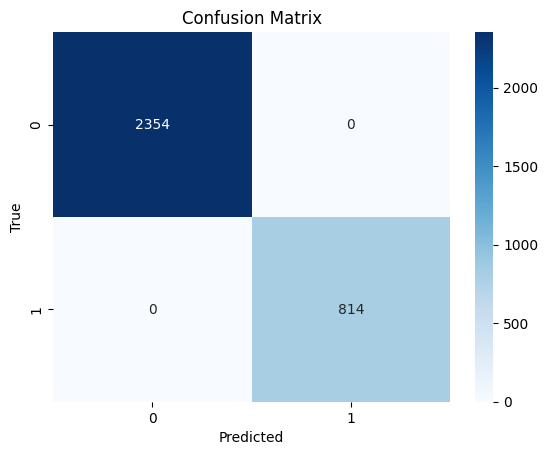

In [894]:
hetero_gnn.eval()

with torch.no_grad():
    out = hetero_gnn(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    out = torch.softmax(out["hex"], dim=-1)

    new_results = roc_auc_score(
        data["hex"].y.cpu().numpy(),
        out[:, 1].cpu().numpy(),
        average="micro",
    )
    print(f"ROC AUC Score: {new_results}")
    # Assuming you have the true labels in the variable 'true_labels' and the predicted labels in the variable 'predicted_labels'
    cm = confusion_matrix(
        data["hex"].y.cpu().numpy(), torch.argmax(out, dim=1).cpu().numpy()
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Set labels and title
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Show the plot
    plt.show()

In [ ]:
y_pred = torch.argmax(out, dim=1).cpu().numpy()

results_gdf = controller.hexes_gdf[
    controller.hexes_gdf.columns[~controller.hexes_gdf.columns.isin(hexes_attr_columns)]
].join(pd.Series(y_pred, name="y_pred"))

error_column = np.where(
    (results_gdf["accident_occured"] == 1) & (results_gdf["y_pred"] == 0),
    "FN",
    np.where(
        (results_gdf["accident_occured"] == 0) & (results_gdf["y_pred"] == 1),
        "FP",
        "No error",
    ),
)

results_gdf["error"] = error_column


def cmap_fn(a):
    data = a["properties"]["error"]
    if data == "FN":
        return "red"
    elif data == "FP":
        return "orange"
    else:
        return "blue"


results_gdf.explore(
    column="error",
    categorical=True,
    style_kwds=dict(
        fillOpacity=0.3,
        opacity=0.1,
        style_function=lambda feature: dict(fillColor=cmap_fn(feature)),
    ),
)

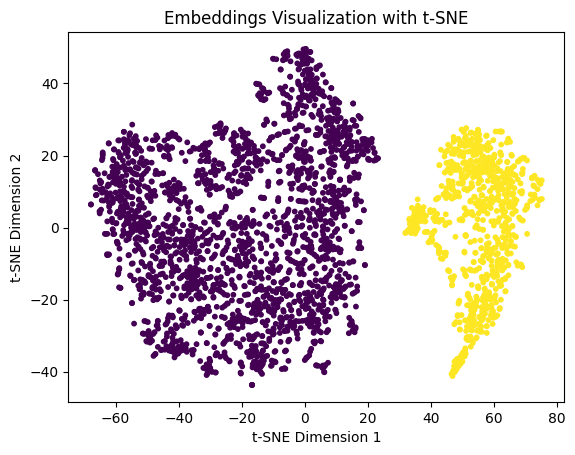

In [896]:
embs = hetero_gnn.get_embeddings(
    data.x_dict, data.edge_index_dict, data.edge_attr_dict
)["hex"]


# Convert the embeddings tensor to a numpy array
embeddings = embs.detach().cpu().numpy()

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)

# Get the ground truth labels
labels = data["hex"].y.cpu().numpy()

# Create a scatter plot of the embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, s=10)

# Add labels and title to the plot
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Embeddings Visualization with t-SNE")

# Show the plot
plt.show()